# Nettoyage des données

### Importation des librairies

In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Chargement de la base de donnée

In [2]:
df = pd.read_csv("Data/en.openfoodfacts.org.products.csv", sep= "\t")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,8,13,19,20,21,22,23,27,28,29,31,32,33,38,40,41,42,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# on prend la variable code comme index
df = df.drop_duplicates(subset='code')
df = df.set_index('code')

# on crée la base de donnée qui sera utilisée
df_cheese = df[df['pnns_groups_2'] == 'Cheese']

# on supprime l'ancienne inutile
del df

#### Pour avoir un aperçu des valeurs manquantes

<AxesSubplot:ylabel='code'>

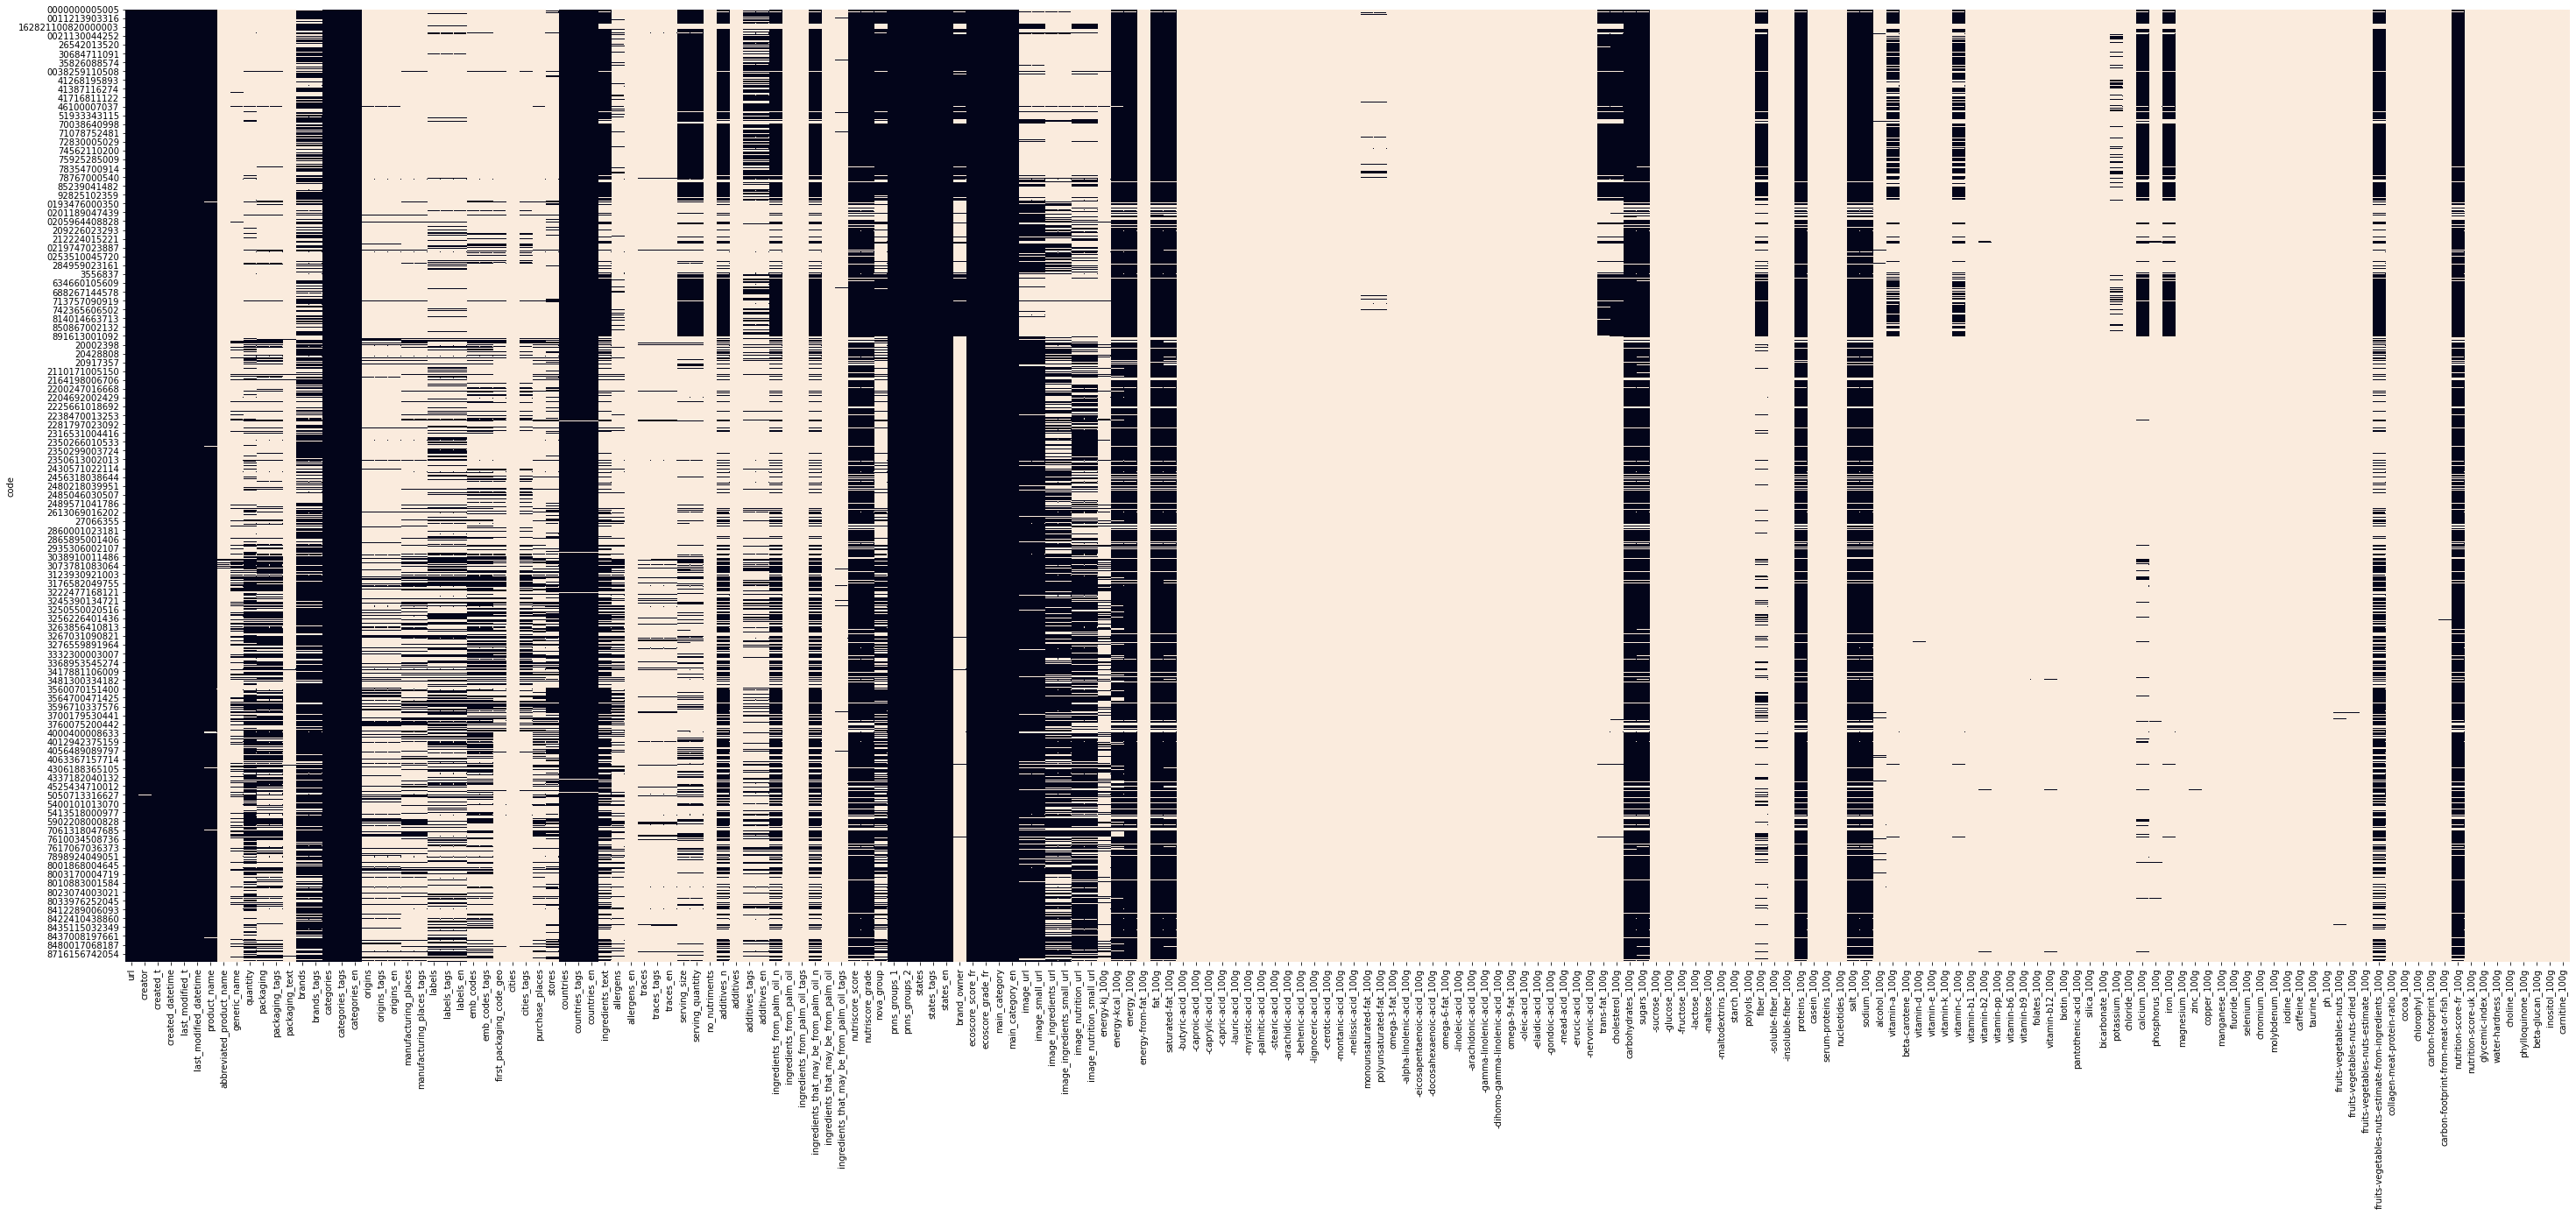

In [4]:
plt.figure(figsize=(50,20))
sns.heatmap(df_cheese.isna(), cbar=False)

## Definition des fonctions utilisées

In [5]:
def multiOnehotTags(serie, liste, en=''):
    '''
    liste est la liste des valeurs qui sont autorisées (recommandé d'utiliser listMainCat).
    la fonction effectue un onehot pour une variable qui a plusieurs valeurs dans une cellule
    '''
    df_temp = pd.DataFrame(columns=liste.keys())
    for i in serie.index:
        val = serie.loc[i]
        if type(val) == str:
            for r in range(val.count(','+ en)+1):
                virgule = val.find(',' + en)
                if virgule == -1:
                    if val[len(en):] in liste:
                        df_temp.loc[i,val[len(en):]] = 1
                    else:
                        df_temp.loc[i] = 0
                else:
                    if val[len(en):virgule] in liste:
                        df_temp.loc[i,val[len(en):virgule]] = 1
                    else:
                        df_temp.loc[i] = 0
                    val = val[virgule + 1:]
        else:
            df_temp.loc[i] = 0
    return df_temp.fillna(0)

In [6]:
def listMainCat(serie, seuil=10, en=''):
    '''
    liste dans la série toutes les valeurs existantes et trie du plus au moins frequent (ne considère pas ceux en dessous du seuil)
    seuil peut être un entier et du coup il ejecte ceux qui sont moins que ce nombre
    ou il peut être une fraction qui est le pourcentage en desous duquel il ejecte
    '''
    serie_temp = pd.Series()
    serie_values = serie.value_counts()
    for i in range(serie_values.shape[0]):
        val = serie_values.index[i]
        for r in range(val.count(',')+1):
            virgule = val.find(',')
            if virgule == -1:
                if val[len(en):] in serie_temp:
                    serie_temp[val[len(en):]] += serie_values[i]
                else:
                    serie_temp[val[len(en):]] = serie_values[i]
            else:
                if val[len(en):virgule] in serie_temp:
                    serie_temp[val[len(en):virgule]] += serie_values[i]
                else:
                    serie_temp[val[len(en):virgule]] = serie_values[i]
                val = val[virgule+1:]
    serie_temp.sort_values(ascending=False, inplace=True)
    if isinstance(seuil, int):
        for i in range(serie_temp.shape[0]):
            if serie_temp.iloc[i] < seuil:
                serie_temp = serie_temp.iloc[0:i]
                break
    elif isinstance(seuil, float):
        for i in range(serie_temp.shape[0]):
            if serie_temp.iloc[i]/serie.shape[0] < seuil:
                serie_temp = serie_temp.iloc[0:i]
                break
    return serie_temp

In [7]:
def histplot(cols, log=False):
    '''
    faire plusieurs histrogrammes dans un bloc
    '''
    plt.figure(figsize=(30,20))
    for i, col in enumerate(cols):
        plt.subplot(3, 3, i+1)
        plt.hist(df_cheese[col], bins=100)
        plt.xlabel(col)
        if log:
            plt.yscale('log')

## Nettoyage

In [4]:
# création d'une variable 'created_year' pour l'année où a été renseigné le produit
df_cheese.loc[df_cheese['created_datetime'].notnull(), 'created_year'] = df_cheese['created_datetime'].str[:4].astype(int)

#### archives pour la selection des colonnes

In [9]:
# liste toutes les colonnes qui ont un taux de vacuité en dessous du seuil
liste = [i for i in df_cheese.columns if df_cheese[i].isna().sum()/df_cheese.shape[0] <= 0.8]
df_cheese_na = df_cheese[liste]

In [10]:
# voir quels tableaux sont les plus vides
pd.DataFrame((df_cheese_na.isna().sum()/df_cheese_na.shape[0] -1).abs())

,0
url,1.000000
creator,0.999957
created_t,1.000000
created_datetime,1.000000
last_modified_t,1.000000
...,...
calcium_100g,0.292393
iron_100g,0.254948
fruits-vegetables-nuts-estimate-from-ingredients_100g,0.562605
nutrition-score-fr_100g,0.892722


<AxesSubplot:>

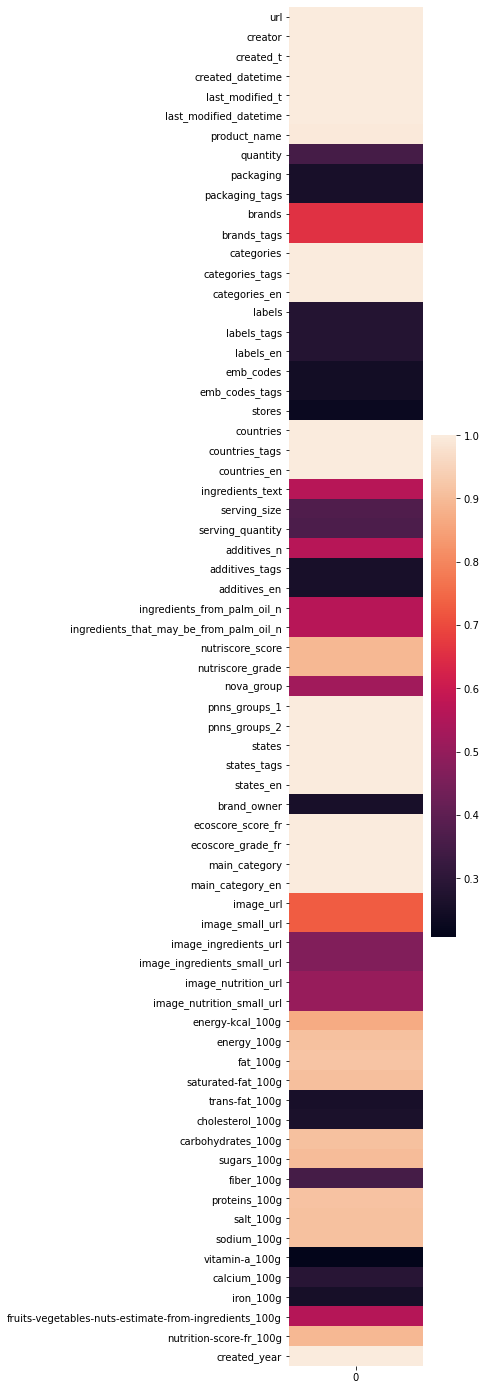

In [11]:
# le voir sur une heatmap
plt.figure(figsize=(3,25))
sns.heatmap(pd.DataFrame((df_cheese_na.isna().sum()/df_cheese_na.shape[0] -1).abs()))

#### selection des colonnes à utiliser

In [5]:
# dans tout le dataset, on ne selectionne que les plus utiles et remplies
df_cheese = df_cheese[['product_name', 'categories_en', 'created_year', 'ecoscore_score_fr', 'countries_tags', 'nutriscore_score',
                       'nova_group', 'labels_tags', 'fat_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g', 'carbohydrates_100g',
                       'saturated-fat_100g', 'sugars_100g', 'energy-kcal_100g']]


#### Suppretion des outliers
pour les variables quantitatives (les nutriments et l'apport energétique) on retire les valeurs abérantes.
- dans un premier temps on visualise les données en base logarithmique pour mettre en avant les individus isolés à supprimer
- ensuite on définit des seuils à partir des graphiques pour garder la tendance générale et supprimer les outliers
- pour finir on visualise le resultat sur une base linéaire pour comparer la différence

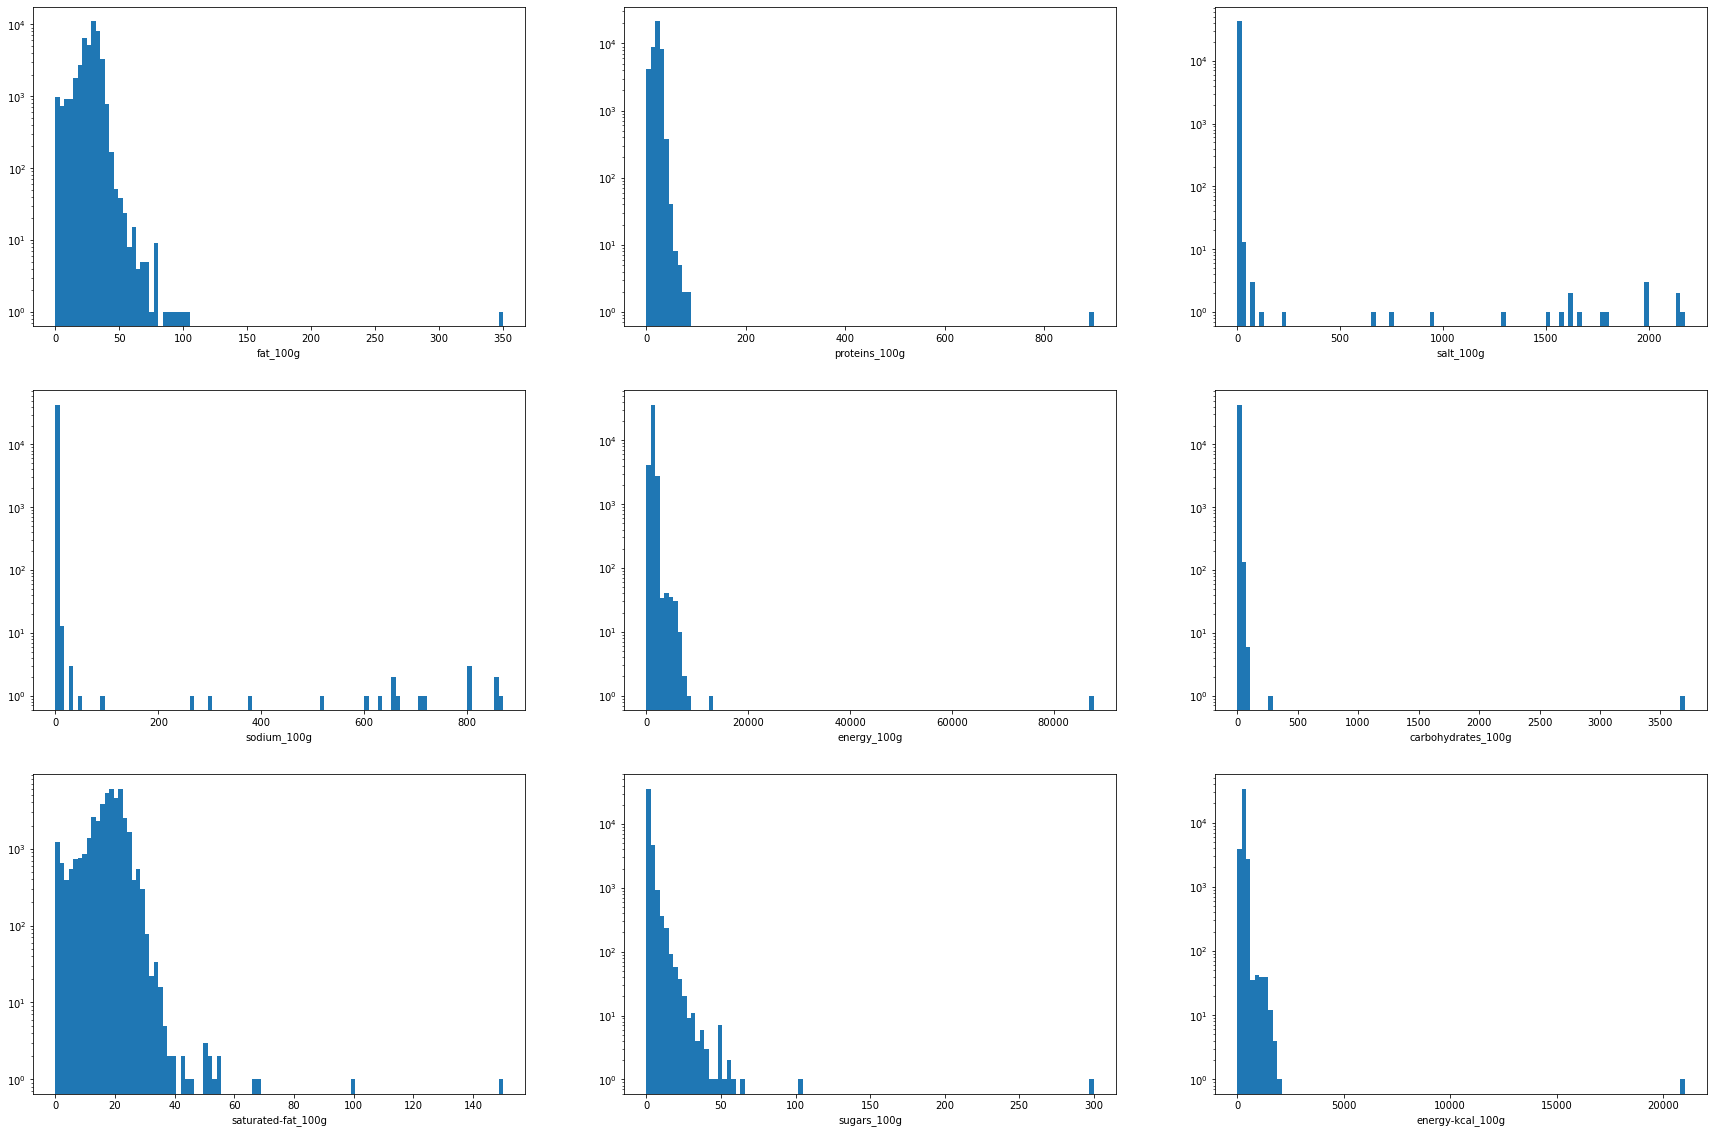

In [13]:
histplot(['fat_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'sugars_100g', 'energy-kcal_100g'], log=True)

In [6]:
# suppression des outliers
individu_initial = df_cheese.shape[0]
df_cheese = df_cheese[(df_cheese['fat_100g'] <= 80) | (df_cheese['fat_100g'].isna())]
df_cheese = df_cheese[(df_cheese['proteins_100g'] <= 55) | (df_cheese['proteins_100g'].isna())]
df_cheese = df_cheese[(df_cheese['salt_100g'] <= 30) | (df_cheese['salt_100g'].isna())]
df_cheese = df_cheese[(df_cheese['sodium_100g'] <= 10) | (df_cheese['sodium_100g'].isna())]
df_cheese = df_cheese[(df_cheese['energy_100g'] <= 7000) | (df_cheese['energy_100g'].isna())]
df_cheese = df_cheese[(df_cheese['carbohydrates_100g'] <= 70) | (df_cheese['carbohydrates_100g'].isna())]
df_cheese = df_cheese[(df_cheese['saturated-fat_100g'] <= 40) | (df_cheese['saturated-fat_100g'].isna())]
df_cheese = df_cheese[(df_cheese['sugars_100g'] <= 40) | (df_cheese['sugars_100g'].isna())]
df_cheese = df_cheese[(df_cheese['energy-kcal_100g'] <= 1500) | (df_cheese['energy-kcal_100g'].isna())]
individu_apres = df_cheese.shape[0]
print('retirer les outliers a fait passer le dataset de ' + str(individu_initial) + ' à ' + str(individu_apres) + ' individus (ça en à retiré ' + str(individu_initial - individu_apres) + ')')

retirer les outliers a fait passer le dataset de 46841 à 46755 individus (ça en à retiré 86)


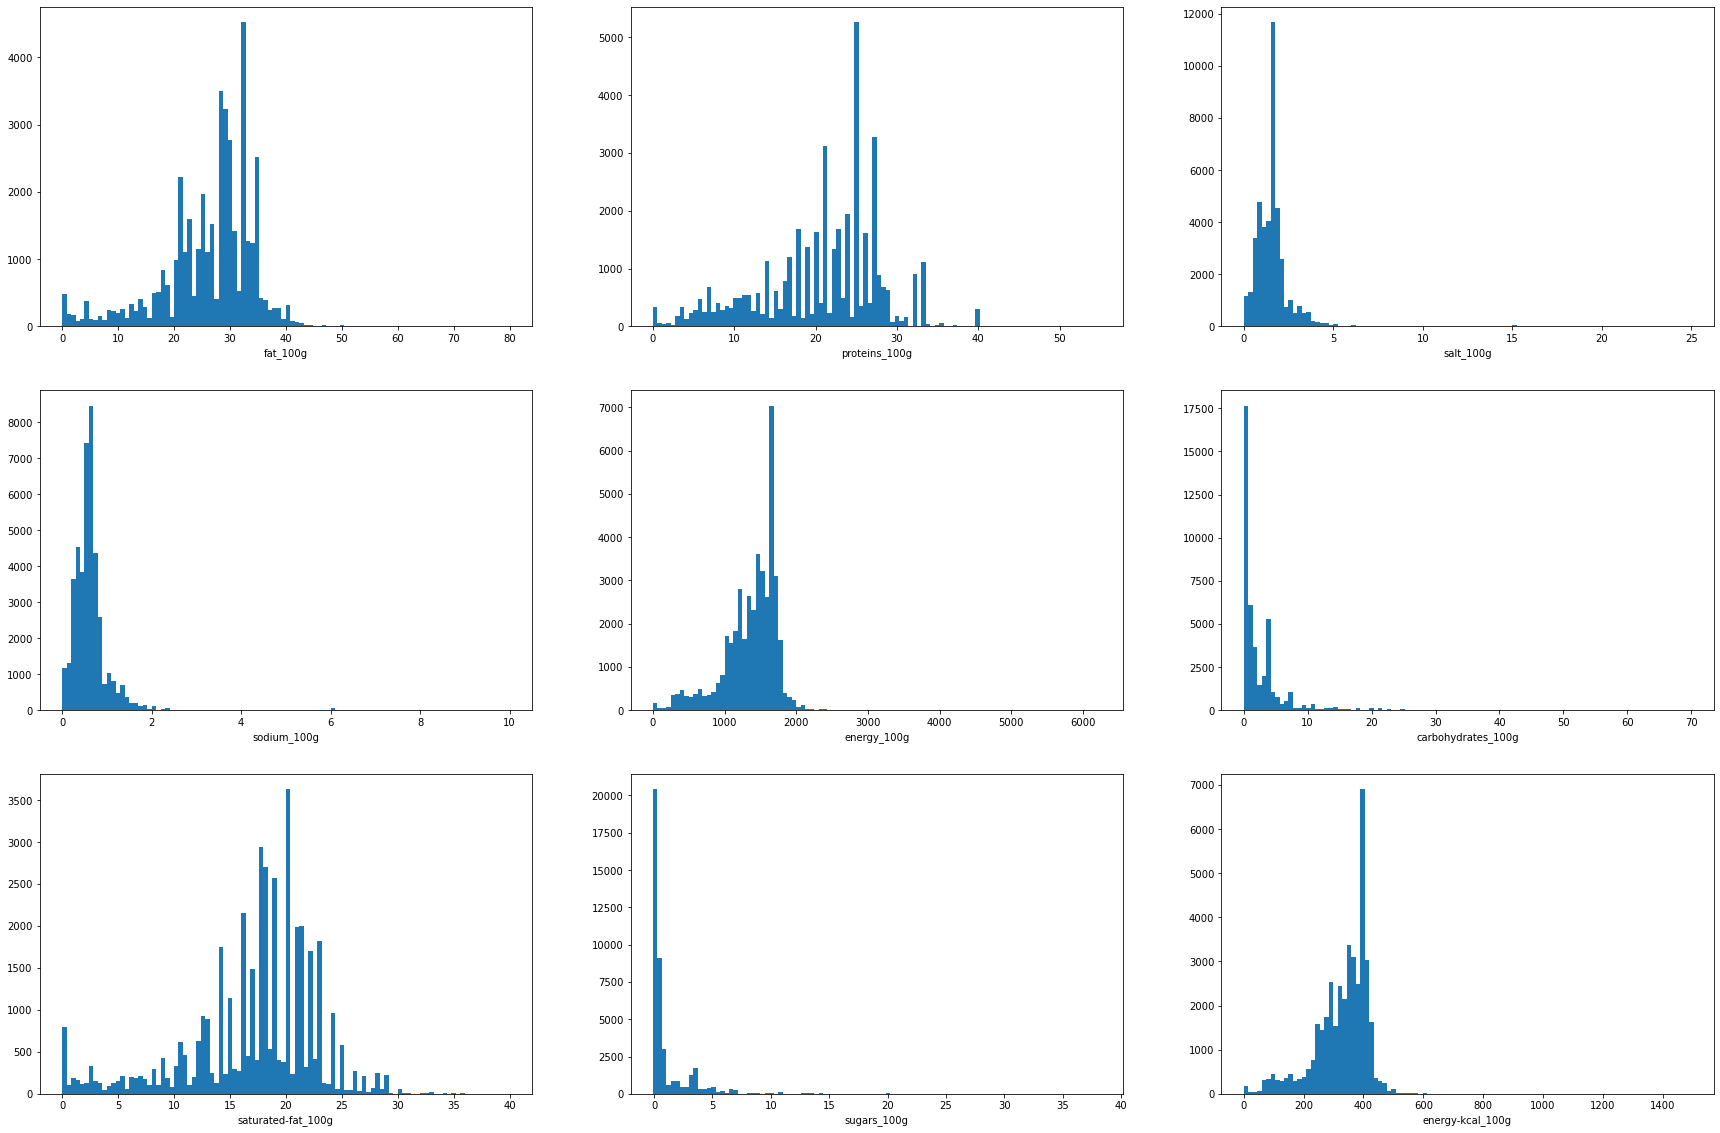

In [15]:
histplot(['fat_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'sugars_100g', 'energy-kcal_100g'])

#### suppression des lignes trop peu remplies
tous les individus qui ont au total moins de valeurs renseignées que le seuil ne sont pas gardées,
on fait évoluer le seuil pour voir à partir de quand on perd trop d'individus dans le dataset.
15 est la valeur qui sera retenue

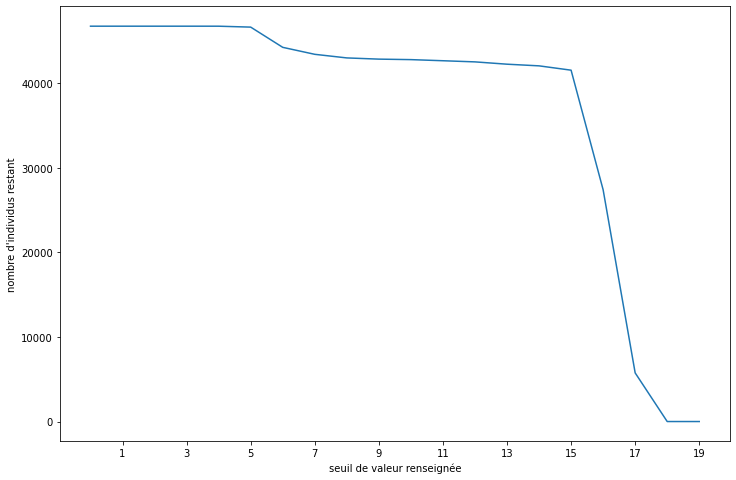

l'opperation ne retirrera que 5203 individus


In [12]:
miss_value = []
for i in range(20):
    miss_value.append(df_cheese.dropna(thresh=i).shape[0])
plt.figure(figsize=(12,8))
plt.plot(range(len(miss_value)), miss_value)
plt.xticks([1,3,5,7,9,11,13,15,17,19])
plt.xlabel("seuil de valeur renseignée")
plt.ylabel("nombre d'individus restant")
plt.show()
print('l\'opperation ne retirrera que ' + str(df_cheese.shape[0] - df_cheese.dropna(thresh=15).shape[0]) + ' individus')

In [17]:
df_cheese.dropna(thresh=15, inplace=True)

#### remplissage des valeurs menquantes
les quantitatives par la moyenne, et les noms de produits, les marques et ingredients_text par 'unknown'.
on voit que pour les variables quantitatives bien souvent il y a que 0.1% environ à compléter donc ça n'a pas une influance énorme sur le dataset

In [18]:
df_cheese[['ecoscore_score_fr', 'nutriscore_score', 'fat_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g',
           'carbohydrates_100g', 'saturated-fat_100g', 'sugars_100g', 'energy-kcal_100g']].notna().sum()/df_cheese.shape[0]

ecoscore_score_fr     0.999928
nutriscore_score      0.998941
fat_100g              0.999976
proteins_100g         0.999952
salt_100g             1.000000
sodium_100g           1.000000
energy_100g           1.000000
carbohydrates_100g    0.999422
saturated-fat_100g    0.999952
sugars_100g           0.999206
energy-kcal_100g      0.956248
dtype: float64

In [19]:
# valeurs quantitatives
df_cheese[['ecoscore_score_fr', 'nutriscore_score', 'fat_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g', 'carbohydrates_100g', 'saturated-fat_100g',
           'sugars_100g', 'energy-kcal_100g']] = df_cheese[['ecoscore_score_fr', 'nutriscore_score', 'fat_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_100g',
                                                            'carbohydrates_100g', 'saturated-fat_100g', 'sugars_100g',
                                                            'energy-kcal_100g']].fillna(df_cheese[['ecoscore_score_fr', 'nutriscore_score', 'fat_100g', 'proteins_100g',
                                                                                                   'salt_100g', 'sodium_100g','energy_100g',
                                                                                                   'carbohydrates_100g', 'saturated-fat_100g',
                                                                                                   'sugars_100g', 'energy-kcal_100g']].mean())
# valeurs qualitatives
df_cheese.fillna({'product_name':'unknown', 'nova_group':'unknown'}, inplace=True)

## Création de nouvelles variables
l'idée est de faire un oneHot des valeurs les plus récurrentes du dataset.
le probleme est qu'il y a plusieurs valeurs dans un seul champ, et des fois il y a un préfixe inutile.
1. unifier les différents préfixe qu'il peut y avoir dans la variable 'labels_tags'
2. lister les valeurs les plus récurrentes à appliquer en oneHot (celles qui sont récurrentes à plus de 2%)
3. pour chaque variable :
    1. créer un dataframe avec le oneHot de chaque valeurs qui sont indiquées dans la liste créée
    2. l'ajouter à notre dataframe initial
    3. supprimer la colonne de la variable utilisée

In [20]:
# unifie tous les différents préfix sous le même préfixe
for i in df_cheese['labels_tags'].index:
    if type(df_cheese['labels_tags'].loc[i]) == str:
        df_cheese['labels_tags'].loc[i] = re.sub('[a-z][a-z]:', '::', df_cheese['labels_tags'].loc[i])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
list_labels = listMainCat(df_cheese['labels_tags'], seuil=0.02, en='::')
list_pays_vente = listMainCat(df_cheese['countries_tags'], seuil=0.02, en='en:')
list_cat_en = listMainCat(df_cheese['categories_en'], seuil=0.02)

<ipython-input-6-97f252e4751e>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  serie_temp = pd.Series()


In [22]:
labels = multiOnehotTags(df_cheese['labels_tags'], list_labels, en='::')
df_cheese = df_cheese.join(labels)
df_cheese.drop('labels_tags', axis=1, inplace=True)

In [23]:
countries = multiOnehotTags(df_cheese['countries_tags'], list_pays_vente, en='en:')
countries.columns = 'sold in ' + countries.columns # pour que le nom de la variable soit plus explicite
df_cheese = df_cheese.join(countries)
df_cheese.drop('countries_tags', axis=1, inplace=True)

In [24]:
categorie = multiOnehotTags(df_cheese['categories_en'], list_cat_en)
df_cheese = df_cheese.join(categorie)
df_cheese.drop('categories_en', axis=1, inplace=True)

# supression des variables inutiles car elles incluent tous les individus
df_cheese.drop(['Dairies', 'Fermented foods', 'Fermented milk products', 'Cheeses'], axis=1, inplace=True)

## exportation du dataset nettoyé

In [25]:
df_cheese.to_csv('Data/cheese_clean.csv')